# `sklearn-mrmr` demo and comparison

More complex model --> the more feature selection will help?

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

sys.path.append(os.path.abspath('sklearn-mrmr'))
from mrmr import MRMRFeatureSelector


## Hospital data

In [3]:
irt = pd.read_csv('~/Downloads/rwm1984_190_27.csv')
irt = irt.drop(['Unnamed: 0', 'X'], axis=1)
irt.head()

,docvis,hospvis,edlevel,age,outwork,female,married,kids,hhninc,educ,self,edlevel1,edlevel2,edlevel3,edlevel4
0,1,0,3,54,0,0,1,0,3.050,15.0,0,0,0,1,0
1,0,0,1,44,1,1,1,0,3.050,9.0,0,1,0,0,0
2,0,0,1,58,1,1,0,0,1.434,11.0,0,1,0,0,0
3,7,2,1,64,0,0,0,0,1.500,10.5,0,1,0,0,0
4,6,0,3,30,1,0,0,0,2.400,13.0,0,0,0,1,0


In [11]:
y = irt['hospvis']
X = irt.drop('hospvis', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

In [12]:
basic_pipeline = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_basic = {
    'regressor__n_estimators': [200],
    'regressor__max_depth': [2, 3, 5, 7, 10, 15, 30],
}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5, scoring='neg_mean_squared_error')

grid_search_basic.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [2, 3, 5, 7, 10, 15, 30],
                         'regressor__n_estimators': [200]},
             scoring='neg_mean_squared_error')

In [13]:
mrmr_pipeline = Pipeline(steps=[
    ('selector', MRMRFeatureSelector(method='ftest', n_features_to_select=3)),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_mrmr = {
    'selector__n_features_to_select': [3, 6, 9, 12],
    'regressor__n_estimators': [200],
    'regressor__max_depth': [2, 3, 5, 7, 10, 15, 30]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5, scoring='neg_mean_squared_error')

grid_search_mrmr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        MRMRFeatureSelector(n_features_to_select=3)),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [2, 3, 5, 7, 10, 15, 30],
                         'regressor__n_estimators': [200],
                         'selector__n_features_to_select': [3, 6, 9, 12]},
             scoring='neg_mean_squared_error')

In [36]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 14

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv_mrmr.head(10)

cv = pd.concat([cv_basic, cv_mrmr])

cv['mean_test_score'] = -1 * cv['mean_test_score']

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.148664,0.008581,0.003299,0.000193,2,200,"{'regressor__max_depth': 2, 'regressor__n_esti...",-0.072989,-0.517042,-0.114231,-0.884843,-0.445948,0.407011,0.296391,1,basic,14
1,0.187033,0.003528,0.004159,0.000844,3,200,"{'regressor__max_depth': 3, 'regressor__n_esti...",-0.078598,-0.536152,-0.115050,-0.921431,-0.457413,0.421729,0.308499,2,basic,14
2,0.260007,0.004459,0.005010,0.000181,5,200,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.116170,-0.564421,-0.134686,-1.058183,-0.502599,0.475212,0.344509,3,basic,14
3,0.335690,0.003276,0.006222,0.000149,7,200,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.162860,-0.563628,-0.151850,-1.117668,-0.526636,0.504528,0.352432,4,basic,14
4,0.413443,0.004944,0.007730,0.000164,10,200,"{'regressor__max_depth': 10, 'regressor__n_est...",-0.189965,-0.571018,-0.162964,-1.118892,-0.542261,0.517020,0.345868,5,basic,14


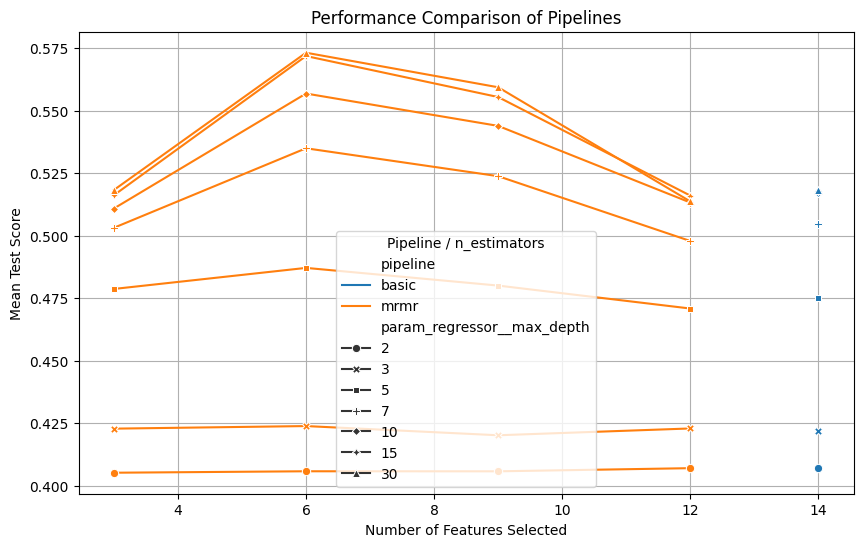

In [38]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'param_regressor__max_depth', 'mean_test_score']]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score', hue='pipeline', style='param_regressor__max_depth', markers=True, dashes=False)

# Set plot labels and title
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Score')
plt.title('Performance Comparison of Pipelines')
plt.legend(title='Pipeline / n_estimators')
plt.grid(True)

# Show the plot
plt.show()

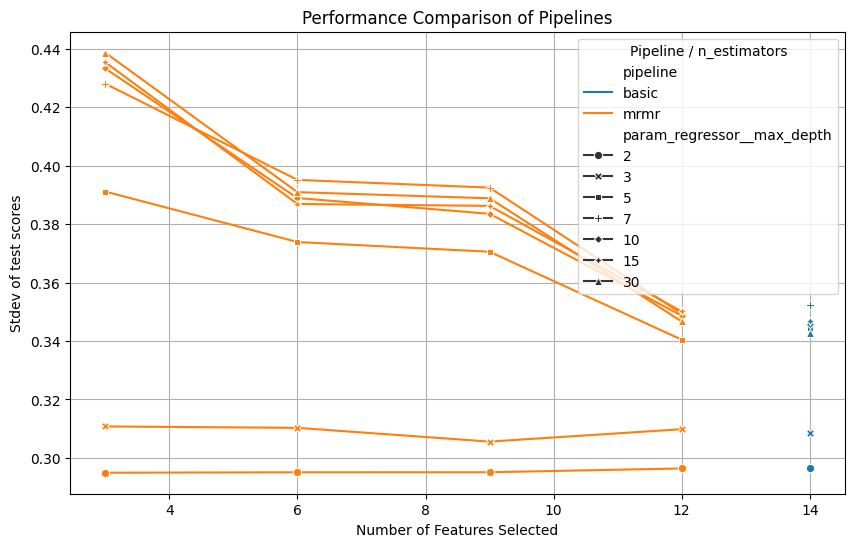

In [39]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'param_regressor__max_depth', 'std_test_score']]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='std_test_score', hue='pipeline', style='param_regressor__max_depth', markers=True, dashes=False)

# Set plot labels and title
plt.xlabel('Number of Features Selected')
plt.ylabel('Stdev of test scores')
plt.title('Performance Comparison of Pipelines')
plt.legend(title='Pipeline / n_estimators')
plt.grid(True)

# Show the plot
plt.show()